<a href="https://colab.research.google.com/github/qbx11/emotion-recognition/blob/main/emotion_recogniction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cuda
Rozkład klas:
emotion
Angry       4953
Fear        5121
Happy       8989
Sad         6077
Surprise    4002
Neutral     6198
Name: count, dtype: int64
Zbiory: Train: 24738, Val: 5301, Test: 5301
Liczba parametrów: 2145542

Rozpoczynam trening...


Epoch 01 | Train Loss: 1.2139 | Val Loss: 1.0768 | Train Acc: 25.33% | Val Acc: 30.86%


Epoch 02 | Train Loss: 1.0459 | Val Loss: 0.9203 | Train Acc: 33.86% | Val Acc: 41.97%


Epoch 03 | Train Loss: 0.9668 | Val Loss: 0.8582 | Train Acc: 39.30% | Val Acc: 46.09%


Epoch 04 | Train Loss: 0.9174 | Val Loss: 0.7888 | Train Acc: 41.88% | Val Acc: 49.93%


Epoch 05 | Train Loss: 0.8858 | Val Loss: 0.7523 | Train Acc: 43.71% | Val Acc: 50.78%


Epoch 06 | Train Loss: 0.8606 | Val Loss: 0.7438 | Train Acc: 44.43% | Val Acc: 51.56%


Epoch 07 | Train Loss: 0.8460 | Val Loss: 0.7118 | Train Acc: 45.66% | Val Acc: 52.86%


Epoch 08 | Train Loss: 0.8209 | Val Loss: 0.7175 | Train Acc: 46.36% | Val Acc: 53.01%


Epoch 09 | Train Loss: 0.8138 | Val Loss: 0.6998 | Train Acc: 46.92% | Val Acc: 53.03%


Epoch 10 | Train Loss: 0.7984 | Val Loss: 0.6684 | Train Acc: 47.94% | Val Acc: 55.10%


Epoch 11 | Train Loss: 0.7832 | Val Loss: 0.6685 | Train Acc: 48.57% | Val Acc: 54.61%


Epoch 12 | Train Loss: 0.7713 | Val Loss: 0.6729 | Train Acc: 49.04% | Val Acc: 54.52%


Epoch 13 | Train Loss: 0.7628 | Val Loss: 0.6494 | Train Acc: 49.07% | Val Acc: 55.69%


Epoch 14 | Train Loss: 0.7566 | Val Loss: 0.6659 | Train Acc: 49.81% | Val Acc: 54.74%


Epoch 15 | Train Loss: 0.7488 | Val Loss: 0.6339 | Train Acc: 50.19% | Val Acc: 57.48%


Epoch 16 | Train Loss: 0.7364 | Val Loss: 0.6389 | Train Acc: 51.16% | Val Acc: 56.44%


Epoch 17 | Train Loss: 0.7222 | Val Loss: 0.6218 | Train Acc: 51.87% | Val Acc: 58.14%


Epoch 18 | Train Loss: 0.7177 | Val Loss: 0.6208 | Train Acc: 52.14% | Val Acc: 57.89%


Epoch 19 | Train Loss: 0.7109 | Val Loss: 0.6212 | Train Acc: 51.91% | Val Acc: 58.61%


Epoch 20 | Train Loss: 0.7074 | Val Loss: 0.5998 | Train Acc: 52.54% | Val Acc: 59.05%


Epoch 21 | Train Loss: 0.6899 | Val Loss: 0.6046 | Train Acc: 53.80% | Val Acc: 59.25%


Epoch 22 | Train Loss: 0.6819 | Val Loss: 0.5902 | Train Acc: 54.36% | Val Acc: 60.40%


Epoch 23 | Train Loss: 0.6797 | Val Loss: 0.6126 | Train Acc: 54.38% | Val Acc: 58.46%


Epoch 24 | Train Loss: 0.6723 | Val Loss: 0.5942 | Train Acc: 54.37% | Val Acc: 59.03%


Epoch 25 | Train Loss: 0.6651 | Val Loss: 0.6005 | Train Acc: 55.25% | Val Acc: 59.54%

--- Testowanie Najlepszego Modelu ---


Testing: 100%|██████████| 83/83 [00:02<00:00, 31.90it/s]



Classification Report:
              precision    recall  f1-score   support

       Angry       0.55      0.45      0.50       743
        Fear       0.45      0.18      0.26       768
       Happy       0.81      0.87      0.84      1348
         Sad       0.42      0.64      0.51       911
    Surprise       0.70      0.75      0.72       601
     Neutral       0.58      0.56      0.57       930

    accuracy                           0.61      5301
   macro avg       0.59      0.58      0.57      5301
weighted avg       0.60      0.61      0.59      5301



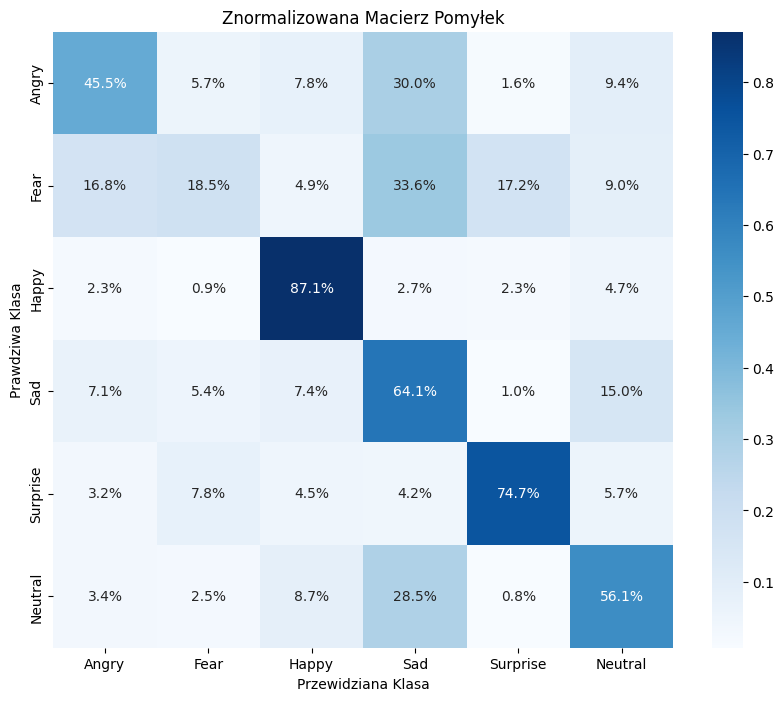

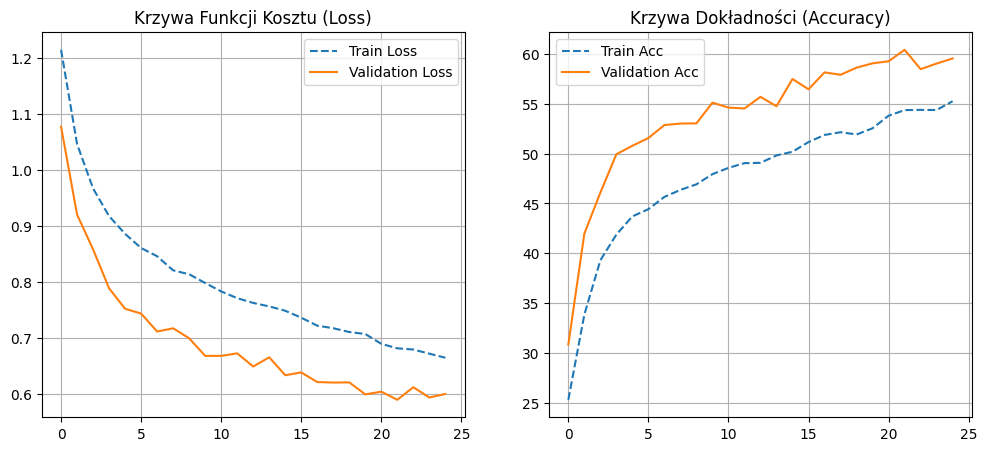


Generowanie przykładów błędów...


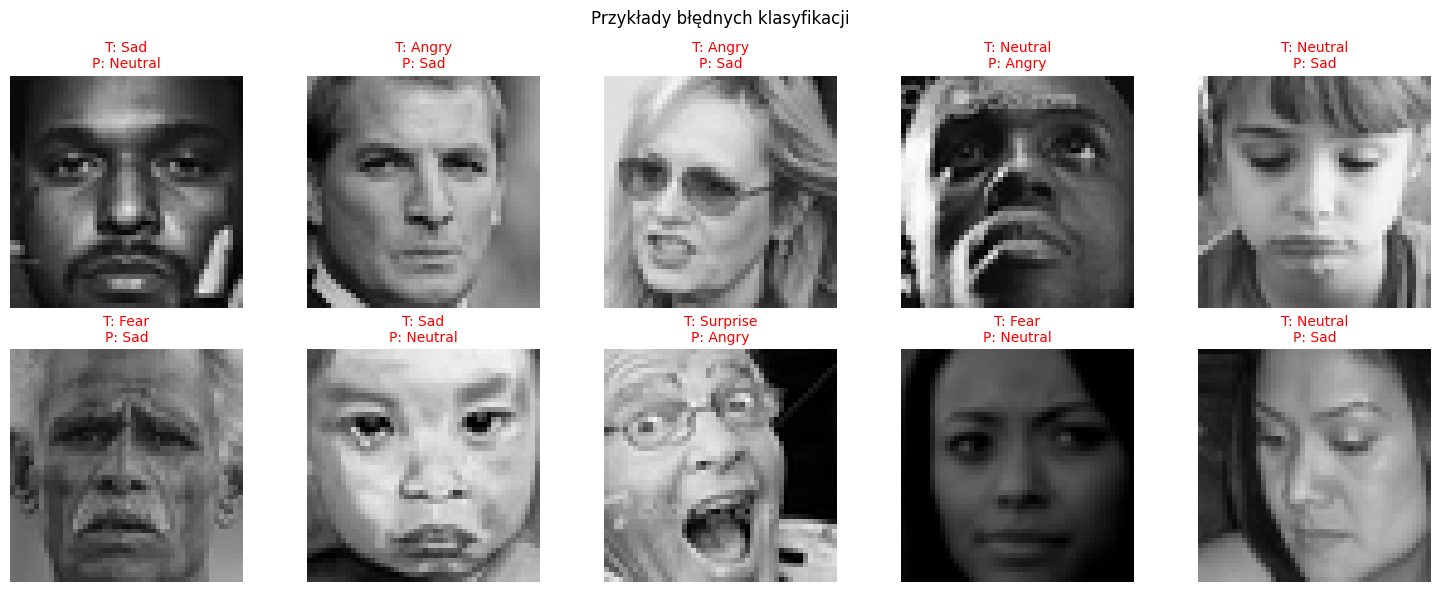

In [2]:
# FER2013 Emotion Recognition

import os
import random
import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as transforms

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

#KONFIGURACJA
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

csv_path = "fer2013.csv"

#PRZYGOTOWANIE DANYCH

if not os.path.exists(csv_path):
    raise FileNotFoundError(f"Nie znaleziono pliku {csv_path}. Upewnij się, że jest w tym samym folderze.")

df = pd.read_csv(csv_path)

def is_valid_pixels(p):
    if not isinstance(p, str):
        return False
    return len(p.split()) == 48 * 48

# Usuwanie uszkodzonych danych
df = df[df["pixels"].apply(is_valid_pixels)].copy()

# Usuwanie klasy 'Disgust'
df = df[df["emotion"] != 1].copy()

# Mapowanie etykiet
label_map = {
    0: 0,  # Angry
    2: 1,  # Fear
    3: 2,  # Happy
    4: 3,  # Sad
    5: 4,  # Surprise
    6: 5   # Neutral
}

emotion_names = {
    0: "Angry",
    1: "Fear",
    2: "Happy",
    3: "Sad",
    4: "Surprise",
    5: "Neutral"
}

df["emotion"] = df["emotion"].map(label_map)
NUM_CLASSES = 6

print("Rozkład klas:")
print(df["emotion"].value_counts().sort_index().rename(index=emotion_names))

#DATASET

class FER2013Dataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        pixels = np.fromstring(row["pixels"], dtype=np.uint8, sep=" ").reshape(48, 48)
        img = Image.fromarray(pixels).convert("RGB")

        if self.transform:
            img = self.transform(img)

        label = int(row["emotion"])
        return img, torch.tensor(label, dtype=torch.long)

def get_transforms(train=True):
    if train:
        return transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(15),
            transforms.RandomAffine(
                degrees=0,
                translate=(0.05, 0.05),
                scale=(0.95, 1.05)
            ),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.ToTensor(),
            transforms.Normalize([0.5]*3, [0.5]*3)
        ])
    else:
        return transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5]*3, [0.5]*3)
        ])

# Podział danych
df_train, df_temp = train_test_split(
    df, test_size=0.30, stratify=df["emotion"], random_state=SEED
)
df_val, df_test = train_test_split(
    df_temp, test_size=0.5, stratify=df_temp["emotion"], random_state=SEED
)

train_ds = FER2013Dataset(df_train, get_transforms(train=True))
val_ds   = FER2013Dataset(df_val,   get_transforms(train=False))
test_ds  = FER2013Dataset(df_test,  get_transforms(train=False))

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=64, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

print(f"Zbiory: Train: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}")

#ARCHITEKTURA MODELU

class EmotionCNN(nn.Module):
    def __init__(self, num_classes=6):
        super().__init__()

        def block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2)
            )

        self.features = nn.Sequential(
            block(3, 64),     # 48x48 -> 24x24
            block(64, 128),   # 24x24 -> 12x12
            block(128, 256),  # 12x12 -> 6x6
            block(256, 256)   # 6x6 -> 3x3
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 3 * 3, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5), # Ważne dla redukcji overfittingu
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = EmotionCNN(NUM_CLASSES).to(device)
print("Liczba parametrów:", sum(p.numel() for p in model.parameters()))

#TRENING

class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0):
        super().__init__()
        self.gamma = gamma
        self.ce = nn.CrossEntropyLoss(reduction="none")

    def forward(self, logits, targets):
        ce_loss = self.ce(logits, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss
        return focal_loss.mean()

criterion = FocalLoss(gamma=2.0)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def train_epoch(model, loader):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for x, y in tqdm(loader, leave=False, desc="Training"):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        correct += (out.argmax(1) == y).sum().item()
        total += y.size(0)

    return total_loss / total, 100 * correct / total

def eval_epoch(model, loader):
    model.eval()
    total_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)

            total_loss += loss.item() * x.size(0)
            correct += (out.argmax(1) == y).sum().item()
            total += y.size(0)

    return total_loss / total, 100 * correct / total

# Pętla główna
EPOCHS = 25
best_val_acc = 0.0

history = {
    "train_acc": [], "val_acc": [],
    "train_loss": [], "val_loss": []
}

print("\nRozpoczynam trening...")
for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc = train_epoch(model, train_loader)
    va_loss, va_acc = eval_epoch(model, val_loader)

    history["train_loss"].append(tr_loss)
    history["val_loss"].append(va_loss)
    history["train_acc"].append(tr_acc)
    history["val_acc"].append(va_acc)

    print(f"Epoch {epoch:02d} | Train Loss: {tr_loss:.4f} | Val Loss: {va_loss:.4f} | Train Acc: {tr_acc:.2f}% | Val Acc: {va_acc:.2f}%")

    #Checkpointing
    if va_acc > best_val_acc:
        best_val_acc = va_acc
        torch.save(model.state_dict(), "best_model.pth")

#EWALUACJA KOŃCOWA

model.load_state_dict(torch.load("best_model.pth"))
model.eval()

all_preds, all_labels = [], []

with torch.no_grad():
    for x, y in tqdm(test_loader, desc="Testing"):
        x = x.to(device)
        out = model(x)
        all_preds.extend(out.argmax(1).cpu().numpy())
        all_labels.extend(y.numpy())

print("\nClassification Report:")
print(classification_report(
    all_labels, all_preds,
    target_names=[emotion_names[i] for i in range(NUM_CLASSES)]
))

# Macierz pomyłek (Znormalizowana)
cm = confusion_matrix(all_labels, all_preds, normalize='true')
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, annot=True, fmt=".1%", cmap="Blues",
    xticklabels=emotion_names.values(),
    yticklabels=emotion_names.values()
)
plt.xlabel("Przewidziana Klasa")
plt.ylabel("Prawdziwa Klasa")
plt.title("Znormalizowana Macierz Pomyłek")
plt.show()

# Wykresy uczenia
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss', linestyle='--')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Krzywa Funkcji Kosztu (Loss)')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Acc', linestyle='--')
plt.plot(history['val_acc'], label='Validation Acc')
plt.title('Krzywa Dokładności (Accuracy)')
plt.legend()
plt.grid()
plt.show()

#WIZUALIZACJA BŁĘDÓW

def visualize_misclassified_images(model, test_loader, classes, device, num_images=10):
    """Wyświetla przykłady zdjęć, na których model się pomylił."""
    model.eval()
    misclassified = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            idxs_mask = (preds != labels).view(-1)
            wrong_idxs = np.where(idxs_mask.cpu().numpy() == True)[0]

            for idx in wrong_idxs:
                if len(misclassified) < num_images:
                    misclassified.append({
                        "image": images[idx].cpu(),
                        "true_label": classes[labels[idx].item()],
                        "pred_label": classes[preds[idx].item()]
                    })
                else:
                    break
            if len(misclassified) >= num_images:
                break

    plt.figure(figsize=(15, 6))
    for i, item in enumerate(misclassified):
        plt.subplot(2, 5, i + 1)
        img = item["image"].permute(1, 2, 0).numpy()
        img = img * 0.5 + 0.5
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        plt.title(f"T: {item['true_label']}\nP: {item['pred_label']}", color='red', fontsize=10)
        plt.axis('off')

    plt.suptitle("Przykłady błędnych klasyfikacji")
    plt.tight_layout()
    plt.show()

print("\nGenerowanie przykładów błędów...")
class_names_list = [emotion_names[i] for i in range(NUM_CLASSES)]
visualize_misclassified_images(model, test_loader, class_names_list, device)